In [1]:
import sys
import pandas
import numpy as np

_rnaResidues = ['A', 'C', 'U', 'G']

def parsePDB(pdb_file):
    """Transforms the pdb file into a pandas table for easy access and data editing."""

    def pdb_line(line):
        return dict(recname=str(line[0:6]).strip(),  # record name
                    serial=int(line[6:11]),          # atom serial number
                    name=str(line[12:16]).strip(),   # atom name
                    altLoc=str(line[16:17]),         # alternate location indicator
                    resname=str(line[17:20]).strip(),
                    chainID=str(line[21:22]),
                    resSeq=int(line[22:26]),         # residue sequence number
                    iCode=str(line[26:27]),          # code for insertion of residues
                    x=float(line[30:38]),
                    y=float(line[38:46]),
                    z=float(line[46:54]),
                    occupancy=1.0 if line[54:60].strip() == '' else float(line[54:60]), # set to 1.0 because Plumed RMSD need 1.0
                    tempFactor=1.0 if line[60:66].strip() == '' else float(line[60:66]),
                    element=str(line[76:78]),        # element symbol, right-justified
                    charge=str(line[78:80]))         # charge on the atom, right-justified

    with open(pdb_file, 'r') as pdb:
        lines = []
        for line in pdb:
            if len(line) > 6 and line[:6] in ['ATOM  ', 'HETATM']:
                lines += [pdb_line(line)]
    pdb_atoms = pandas.DataFrame(lines)
    pdb_atoms = pdb_atoms[['recname', 'serial', 'name', 'altLoc',
                           'resname', 'chainID', 'resSeq', 'iCode',
                           'x', 'y', 'z', 'occupancy', 'tempFactor',
                           'element', 'charge']]
    return pdb_atoms

In [5]:
def CoarseGrain(pdb_table):
    """ Selects RNA atoms from a pdb table and returns a table containing only the coarse-grained atoms for 3SPN2"""
    masses = {"H": 1.00794, "C": 12.0107, "N": 14.0067, "O": 15.9994, "P": 30.973762, }
    CG = {"O5\'": 'P', "C5\'": 'S', "C4\'": 'S', "O4\'": 'S', "C3\'": 'S', "O3\'": 'P', "O2\'": 'S',
            "C2\'": 'S', "C1\'": 'S', "O5*": 'P', "C5*": 'S', "C4*": 'S', "O4*": 'S',
            "C3*": 'S', "O3*": 'P', "C2*": 'S', "C1*": 'S', "N1": 'B', "C2": 'B', "O2": 'B',
            "N2": 'B', "N3": 'B', "C4": 'B', "N4": 'B', "C5": 'B', "C6": 'B', "N9": 'B',
            "C8": 'B', "O6": 'B', "N7": 'B', "N6": 'B', "O4": 'B', "C7": 'B', "P": 'P',
            "OP1": 'P', "OP2": 'P', "O1P": 'P', "O2P": 'P', "OP3": 'P', "HO5'": 'P',
            "H5'": 'S', "H5''": 'S', "H4'": 'S', "H3'": 'S', "H2'": 'S', "H2''": 'S',
            "H1'": 'S', "H8": 'B', "H61": 'B', "H62": 'B', 'H2': 'B', 'H1': 'B', 'H21': 'B',
            'H22': 'B', 'H3': 'B', 'H71': 'B', 'H72': 'B', 'H73': 'B', 'H6': 'B', 'H41': 'B',
            'H42': 'B', 'H5': 'B', "HO3'": 'P'}
    cols = ['recname', 'serial', 'name', 'altLoc',
            'resname', 'chainID', 'resSeq', 'iCode',
            'x', 'y', 'z', 'occupancy', 'tempFactor',
            'element', 'charge', 'type']
    temp = pdb_table.copy()

    # Select RNA residues
    temp = temp[temp['resname'].isin(['A', 'U', 'G', 'C'])]

    # Group the atoms by sugar, phosphate or base
    temp['group'] = temp['name'].replace(CG) # Replace the true atom to group name and add in a new column group
    temp = temp[temp['group'].isin(['P', 'S', 'B'])]

    # Move the O3' to the next residue
    for c in temp['chainID'].unique():
        sel = temp.loc[(temp['name'] == "O3\'") & (temp['chainID'] == c), "resSeq"]
        temp.loc[(temp['name'] == "O3\'") & (temp['chainID'] == c), "resSeq"] = list(sel)[1:] + [-1] # add the resseq 1, the last is -1
        sel = temp.loc[(temp['name'] == "O3\'") & (temp['chainID'] == c), "resname"]
        temp.loc[(temp['name'] == "O3\'") & (temp['chainID'] == c), "resname"] = list(sel)[1:] + ["remove"]
    # temp = temp[temp['resSeq'] > 0]
    temp = temp[temp['resname'] != 'remove']

    # Calculate center of mass
    temp['element'] = temp['element'].str.strip()
    temp['mass'] = temp.element.replace(masses).astype(float)
    temp[['x', 'y', 'z']] = (temp[['x', 'y', 'z']].T * temp['mass']).T[['x', 'y', 'z']]
    temp = temp[temp['element'] != 'H']  # Exclude hydrogens
    Coarse = temp.groupby(['chainID', 'resSeq', 'resname', 'group']).sum().reset_index()
    Coarse[['x', 'y', 'z']] = (Coarse[['x', 'y', 'z']].T / Coarse['mass']).T[['x', 'y', 'z']]

    # Set pdb columns
    Coarse['recname'] = 'ATOM'
    Coarse['name'] = Coarse['group']
    Coarse['altLoc'] = ''
    Coarse['iCode'] = ''
    Coarse['charge'] = ''
    # Change name of base to real base
    mask = (Coarse.name == 'B')
    Coarse.loc[mask, 'name'] = Coarse[mask].resname.str[-1]  # takes last letter from the residue name
    Coarse['type'] = Coarse['name']
    # Set element (depends on base)
    Coarse['element'] = Coarse['name'].replace({'P': 'P', 'S': 'H', 'A': 'N', 'U': 'S', 'G': 'C', 'C': 'O'})
    # Remove P from the beggining
    drop_list = []
    for chain in Coarse.chainID.unique():
        sel = Coarse[Coarse.chainID == chain]
        drop_list += list(sel[(sel.resSeq == sel.resSeq.min()) & sel['name'].isin(['P'])].index)
    Coarse = Coarse.drop(drop_list)
    # Renumber
    Coarse.index = range(len(Coarse))
    Coarse['serial'] = Coarse.index
    return Coarse[cols]

In [6]:
test1 = parsePDB('/mnt/d/linux/20201015_rna_without_pdb/rna_only_clean/1DDY.pdb')
test2 = CoarseGrain(test1)

In [7]:
test2

,recname,serial,name,altLoc,resname,chainID,resSeq,iCode,x,y,z,occupancy,tempFactor,element,charge,type
0,ATOM,0,G,,G,A,1,,56.368210,-5.571135,13.918110,11.0,413.00,C,,G
1,ATOM,1,S,,G,A,1,,55.362541,-2.668479,17.443935,7.0,338.06,H,,S
2,ATOM,2,G,,G,A,2,,53.475732,-5.969017,10.687574,11.0,479.77,C,,G
3,ATOM,3,P,,G,A,2,,52.046347,-1.483827,16.323974,5.0,262.82,P,,P
4,ATOM,4,S,,G,A,2,,53.044596,-1.488029,11.614015,7.0,333.66,H,,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,ATOM,411,P,,A,G,634,,9.875011,-35.067840,15.008825,5.0,189.58,P,,P
412,ATOM,412,S,,A,G,634,,8.507730,-39.465495,15.069399,7.0,277.99,H,,S
413,ATOM,413,A,,A,G,635,,11.438595,-41.860590,10.015020,10.0,307.27,N,,A
414,ATOM,414,P,,A,G,635,,11.911908,-40.364062,16.090121,5.0,209.36,P,,P


In [17]:
p_atom = test2[test2['name']=='P']
s_atom = test2[test2['name']=='S']

In [45]:
a = list(p_atom.iterrows())

In [67]:
import numpy as np
distance_all = []

for each_item in a:
    index = each_item[1]['resSeq']
    chain_id = each_item[1]['chainID']
    x1 = each_item[1].x
    y1 = each_item[1].y
    z1 = each_item[1].z

    residue2 = s_atom[(s_atom['resSeq'] == index) & (s_atom['chainID'] == chain_id)].iloc[0] # Default, only one residue will be count
    #print(type(residue2))
    x2 = residue2.x
    y2 = residue2.y
    z2 = residue2.z

    xyz_1 = np.array((x1, y1, z1))
    xyz_2 = np.array((x2, y2, z2))

    dist = np.linalg.norm(xyz_2-xyz_1)
    distance_all.append(dist)

(array([1.0000e+01, 1.1000e+01, 1.4000e+01, 1.3600e+02, 1.0090e+03,
        4.6580e+03, 2.2318e+04, 2.5842e+04, 8.6000e+02, 1.1800e+02]),
 array([2.50848548, 2.8075702 , 3.10665492, 3.40573964, 3.70482436,
        4.00390908, 4.3029938 , 4.60207852, 4.90116324, 5.20024796,
        5.49933268]),
 <BarContainer object of 10 artists>)

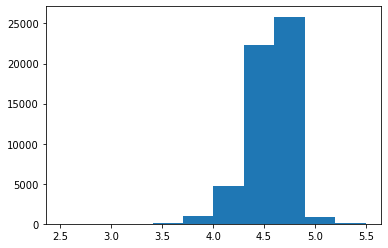

In [94]:
import matplotlib.pyplot as plt
import numpy as np
txt = np.loadtxt('/mnt/d/linux/20201015_rna_without_pdb/all_bond.txt')
#print(type(list(txt)[0]))
distance_all = txt[ (txt >= 2.5) & (txt <=5.5) ]

plt.hist(distance_all)

[5.97478640e-05 1.19495728e-04 1.79243592e-04 1.19495728e-04
 1.19495728e-04 0.00000000e+00 1.79243592e-04 5.97478640e-05
 3.58487184e-04 5.97478640e-05 5.97478640e-05 0.00000000e+00
 1.79243592e-04 1.19495728e-04 4.77982912e-04 4.77982912e-04
 8.96217960e-04 8.36470096e-04 2.50941029e-03 3.40562825e-03
 5.01882058e-03 8.00621378e-03 9.67915397e-03 1.45784788e-02
 2.30029276e-02 3.63864492e-02 5.06064408e-02 6.39899624e-02
 6.67383641e-02 6.05843341e-02 6.22572743e-02 7.94049113e-02
 1.36822609e-01 2.94855709e-01 7.60112326e-01 1.00000000e+00
 2.92645038e-01 9.74487662e-02 8.53199498e-02 6.85905479e-02
 3.59682141e-02 1.06351198e-02 2.92764534e-03 1.01571369e-03
 8.36470096e-04 1.25470514e-03 1.49369660e-03 1.49369660e-03
 1.73268806e-03 1.07546155e-03]
[35]
[2.50848548 2.56830242 2.62811937 2.68793631 2.74775326 2.8075702
 2.86738714 2.92720409 2.98702103 3.04683798 3.10665492 3.16647186
 3.22628881 3.28610575 3.3459227  3.40573964 3.46555658 3.52537353
 3.58519047 3.64500742 3.704824

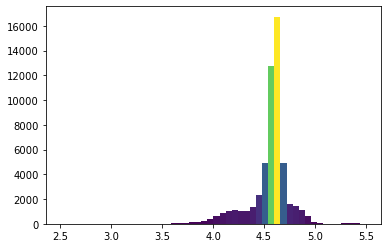

In [101]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

fig, axs = plt.subplots()
n_bins = 50

#plt.xlim(3, 5)

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs.hist(distance_all, bins=n_bins)


# We'll color code by height, but you could use any scalar
fracs = N / N.max()
max_fracs = max(fracs)
sub_index = [i for i, j in enumerate(fracs) if j == max_fracs]
print((bins[sub_index]+bins[sub_index+1])/2)

# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())
#print(fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

# We can also normalize our inputs by the total number of counts
#axs.hist(distance_all, bins=n_bins, density=True)

# Now we format the y-axis to display percentage
#axs.yaxis.set_major_formatter(PercentFormatter(xmax=1))